## Finding insights from instagram data:

In [ ]:
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
import os
import matplotlib.pyplot as plt

### Loading Dataset

In [ ]:
data = json.loads(open(os.path.join("_data", "raw", "ig_posts_data.json")).read())

In [ ]:
df = pd.DataFrame.from_dict(data)
df.head(5)

### Engagements

In [ ]:
df['engagements']  = df['comment'] + df['likes']

#### Stats

In [15]:
print("Total users:", len(df.username.unique()))

print("----")
print("Min followers:", df.followed_by.min())
print("Max followers:", df.followed_by.max())
print("Mean followers:", df.followed_by.mean())

print("----")
print("Min engagements:", df.engagements.min())
print("Max engagements:", df.engagements.max())
print("Mean engagements:", df.engagements.mean())

print("----")
print("Engagement/Followers ratio:", np.divide(df.engagements.mean(), df.followed_by.mean(), dtype=float))

Total users: 93
----
Min followers: 2578
Max followers: 104300407
Mean followers: 11438540.1013
----
Min engagements: 26
Max engagements: 6778179
Mean engagements: 161537.122061
----
Engagement/Followers ratio: 0.0141221799838


#### Correlation between Enagements and followers:

In [16]:
df['engagements'].corr(df['followed_by'])

0.67391050277377484

**Regression between followers and engagements**

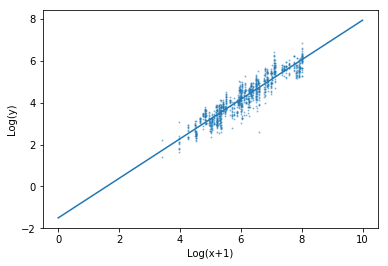

In [17]:
from scipy.stats import linregress

x = df['followed_by']
y = df['engagements']
slope, intercept, r_value, p_value, std_err = linregress(np.log10(x+1), np.log10(y))

xfid = np.linspace(0,10)

plt.scatter(np.log10(x+1), np.log10(y), marker="o", s=1, alpha=0.4)
plt.plot(xfid, xfid*slope+intercept)
plt.xlabel('Log(x+1)')
plt.ylabel('Log(y)')
plt.show()

### Experiment 1 (Features: Caption and Followers ---> Engagements)

In [18]:
exp1_dataset = pd.DataFrame(df[["engagements", 'followed_by', 'caption']])

**Vectorizing followers and caption**

In [19]:
from sklearn.feature_extraction import DictVectorizer

vec = DictVectorizer()

train_features  = []
for i, row in exp1_dataset.iterrows():
    train_features.append({"caption":row['caption'], "followed_by":row['followed_by']})
    
features = vec.fit_transform(train_features).toarray()
target = exp1_dataset['engagements']

**Splitting Dataset into 80:20**

In [20]:
split_ratio = 0.8

train_x = features[:int(len(features)*split_ratio)]
test_x = features[int(len(features)*split_ratio):]

train_y = target[:int(len(target)*split_ratio)]
test_y = target[int(len(target)*split_ratio):]

train_y.shape

(884,)

**Building Neural Net:**

In [ ]:
import tflearn
import tensorflow as tf


tf.reset_default_graph()

net = tflearn.input_data(shape=[None,len(train_x[0])], name='input')
net = tflearn.fully_connected(net, 200)
net = tflearn.fully_connected(net, 200)
net = tflearn.fully_connected(net, 1, activation='softmax')
net = tflearn.reshape(net,[-1])
net = tflearn.regression(net, name='targets')

model = tflearn.DNN(net)


model.fit({'input': train_x}, {'targets': train_y}, 
          validation_set=({'input': test_x}, {'targets': test_y}), 
           n_epoch=10000, batch_size=32, show_metric=True)

**Conclusion:**

The features (Followers and caption) are not sufficient to train a neural net to predict social engagements